In this lab you will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function and optimizer
4. Train the network on the training data
5. Test the network on the test data

Using ``torchvision``, it’s extremely easy to load CIFAR10.



How to install a different version of a package

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics import Accuracy
import numpy as np

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Use GPU if available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


0. Hyperparameters

In [4]:
# Hyperparameters
batch_size = 256
learning_rate = 0.001
max_epochs = 25

# Early stopping parameters
best_val = None
num_epochs_no_improve = 0
patience = 10

experiment_name = 'lab_05_model1'

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
The output of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html#datasets) are PILImage images of range [0, 1].
We [transform](https://pytorch.org/vision/stable/transforms.html) them to Tensors of normalized range [-1, 1]. Then we call the [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)



In [5]:
# Fix for SSL certificate issue with torchvision datasets download
# @see https://stackoverflow.com/a/49174340
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Define data transformation pipeline
transform = transforms.Compose([
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10

Files already downloaded and verified
Files already downloaded and verified


Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


In [6]:
import matplotlib.pyplot as plt  # Import library for plotting
import numpy as np  # Import library for numerical computations
from collections import Counter  # Import Counter for counting elements

# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display

# ------------------ Train Loader Section ------------------
# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]
    
print("Trainloader and trainset size:", len(trainloader), len(trainset), new_stat)

# # Get a batch of random training images and their labels
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
# print('Image tensor size', images.shape)
# imshow(torchvision.utils.make_grid(images))

# ------------------ Test Loader Section -----------------
# Similar steps for the test loader
stat = dict(Counter(testset.targets))
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

print("\nTestloader and testset size:", len(testloader), len(testset), new_stat)

Trainloader and trainset size: 196 50000 {'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}

Testloader and testset size: 40 10000 {'cat': 1000, 'ship': 1000, 'plane': 1000, 'frog': 1000, 'car': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


2. Define a Convolution Neural Network.
[network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2) 
        self.batchNorm1 = nn.BatchNorm2d(8)       
        self.batchNorm2 = nn.BatchNorm2d(16)       
        self.batchNorm3 = nn.BatchNorm2d(32)       
        self.batchNorm4 = nn.BatchNorm2d(64)       
        self.batchNorm5 = nn.BatchNorm2d(128)       
        self.batchNorm6 = nn.BatchNorm2d(128)       
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(p=0)

    def forward(self, x):
        x = F.relu(self.batchNorm1(self.conv1(x))) # 32 -> 32
        x = self.pool(F.relu(self.batchNorm2(self.conv2(x)))) # 32 -> 32 -> 16
        x = F.relu(self.batchNorm3(self.conv3(x))) # 16 -> 16
        x = self.pool(F.relu(self.batchNorm4(self.conv4(x)))) # 16 -> 16 -> 8
        x = F.relu(self.batchNorm5(self.conv5(x))) # 8 -> 8
        x = self.pool(F.relu(self.batchNorm6(self.conv6(x)))) # 8 -> 8 -> 4
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

Compute the receptive field of the network

In [8]:
# This line attempts to clone a Git repository using a shell command.
# !git clone https://github.com/Fangyh09/pytorch-receptive-field.git

# This line would move the downloaded directory
# !mv -v pytorch-receptive-field/torch_receptive_field ./

# Import the 'receptive_field' function from the 'torch_receptive_field' library.
# from torch_receptive_field import receptive_field

# Calculate the receptive field of the network 'net' for an input image size of
# 3 channels (RGB) and 32x32 pixels. The 'receptive_field' function would analyze the network architecture and input size to determine
# the receptive field size for each layer and the overall network.
# receptive_field(net, input_size=(3, 32, 32))


3. Define a loss function and optimizer

Let's use a Classification [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#loss-functions) loss and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum.



In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
optim_name = optimizer.__class__.__name__

In [10]:
# TorchMetrics for macro accuracy
macro_acc = Accuracy(task='multiclass', num_classes=10, average='macro').to(device)

4. Train the network on the training data


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [11]:
net.to(device)

for epoch in range(max_epochs):  # loop over the dataset multiple times

    # Switch to training mode
    net.train()
    # Reset macro accuracy each epoch
    macro_acc.reset()
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels] and move to GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()        
        # Training loop: forward pass, backward pass, and optimization
        # 1. Forward pass:
        outputs = net(inputs)  # Pass the input images through the network to get predictions (outputs)
        # 2. Calculate loss:
        loss = criterion(outputs, labels)  # Compute the loss based on the predictions (outputs) and ground truth labels
        # 3. Backward pass:
        loss.backward()  # Backpropagate the loss to calculate gradients for each parameter in the network
        # 4. Optimization step:
        optimizer.step()  # Update the weights and biases of the network based on the calculated gradients
        running_loss += loss.item()
        # Add outputs and labels of current batch
        macro_acc.update(outputs, labels) 
    # Compute macro accuracy of epoch
    train_macro_acc = macro_acc.compute()

    # Switch to evaluation mode on test set
    # (actually it's the test set but no parameter optimization is being performed as network is in eval() mode)
    net.eval()
    macro_acc.reset()
    
    val_running_loss = 0.0
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            # Add outputs and labels of current batch
            macro_acc.update(outputs, labels)
        # Compute macro accuracy of epoch
        val_macro_acc = macro_acc.compute()

    # Log training loss, validation accuracy to TensorBoard
    writer.add_scalar('Loss/train', running_loss / len(trainloader), epoch)
    writer.add_scalars('Macro_Accuracy', {'Train': train_macro_acc, 'Val': val_macro_acc}, epoch)

    print(f'Epoch [{epoch + 1}/{max_epochs}], Loss: {running_loss / len(trainloader):.4f}, Train_Acc : {train_macro_acc:.4f} Validation_Acc: {val_macro_acc:.4f}')

    # Check if it is the best model so far and save it
    if best_val is None or train_macro_acc > best_val:
        best_val = train_macro_acc
        data = {
            'net': net.state_dict(), # network weights
            'opt': optimizer.state_dict(), # optimizer
            'epoch': epoch # current epoch number
        }
        torch.save(data, './models/' + experiment_name + '_lr_' + str(learning_rate) + '_' + optim_name + '_best.pth')
        print('Saved best')
        num_epochs_no_improve = 0
        # Overfitting
        if train_macro_acc/val_macro_acc > 1.10 and epoch > 9:
            # Early stopping
            print("Early stopping triggered due to overfitting (more than 10% of validation).")
            break
    else:
        # Early stopping
        num_epochs_no_improve += 1
        print('num_epochs_no_improve ', num_epochs_no_improve)
        if num_epochs_no_improve > patience:
            print("Early stopping triggered.")
            break


print('Finished Training')
writer.close()

Epoch [1/25], Loss: 1.3948, Train_Acc : 0.4835 Validation_Acc: 0.6096
Saved best
Epoch [2/25], Loss: 0.9341, Train_Acc : 0.6639 Validation_Acc: 0.6761
Saved best
Epoch [3/25], Loss: 0.7496, Train_Acc : 0.7347 Validation_Acc: 0.6680
Saved best
Epoch [4/25], Loss: 0.6311, Train_Acc : 0.7771 Validation_Acc: 0.6951
Saved best
Epoch [5/25], Loss: 0.5415, Train_Acc : 0.8096 Validation_Acc: 0.7536
Saved best
Epoch [6/25], Loss: 0.4555, Train_Acc : 0.8402 Validation_Acc: 0.7617
Saved best
Epoch [7/25], Loss: 0.3828, Train_Acc : 0.8669 Validation_Acc: 0.7564
Saved best
Epoch [8/25], Loss: 0.3199, Train_Acc : 0.8870 Validation_Acc: 0.7294
Saved best
Epoch [9/25], Loss: 0.2613, Train_Acc : 0.9093 Validation_Acc: 0.7621
Saved best
Epoch [10/25], Loss: 0.2175, Train_Acc : 0.9234 Validation_Acc: 0.7546
Saved best
Epoch [11/25], Loss: 0.1731, Train_Acc : 0.9387 Validation_Acc: 0.7933
Saved best
Early stopping triggered due to overfitting (more than 10% of validation).
Finished Training


5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.




In [12]:
from sklearn.metrics import confusion_matrix
# Load best model
checkpoint = torch.load('./models/' + experiment_name + '_lr_' + str(learning_rate) + '_' + optim_name + '_best.pth')
net.load_state_dict(checkpoint['net'])

# Initialize variables to track accuracy
correct = 0
total = 0

true_labels = []
predicted_labels = []

# Disable gradient calculation for better performance during evaluation
with torch.no_grad():
    # Loop over the test loader
    for data in testloader:
        
        # Get the image and label from the current batch
        images, labels = data[0].to(device), data[1].to(device)

        # Get the network's prediction for the image
        output = net(images)
        # smax = torch.nn.Softmax(dim=1)(output.cpu())

        # Find the class with the highest probability
        _, predicted = torch.max(output, 1)  # Equivalent to pred = torch.argmax(output.cpu(), dim=1)

        # Update total number of test images
        total += labels.size(0)  # label.size(0) gives the batch size

        # Count correct predictions
        correct += (predicted == labels).sum().item()  # Count true positives

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print accuracy
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 79.33 %


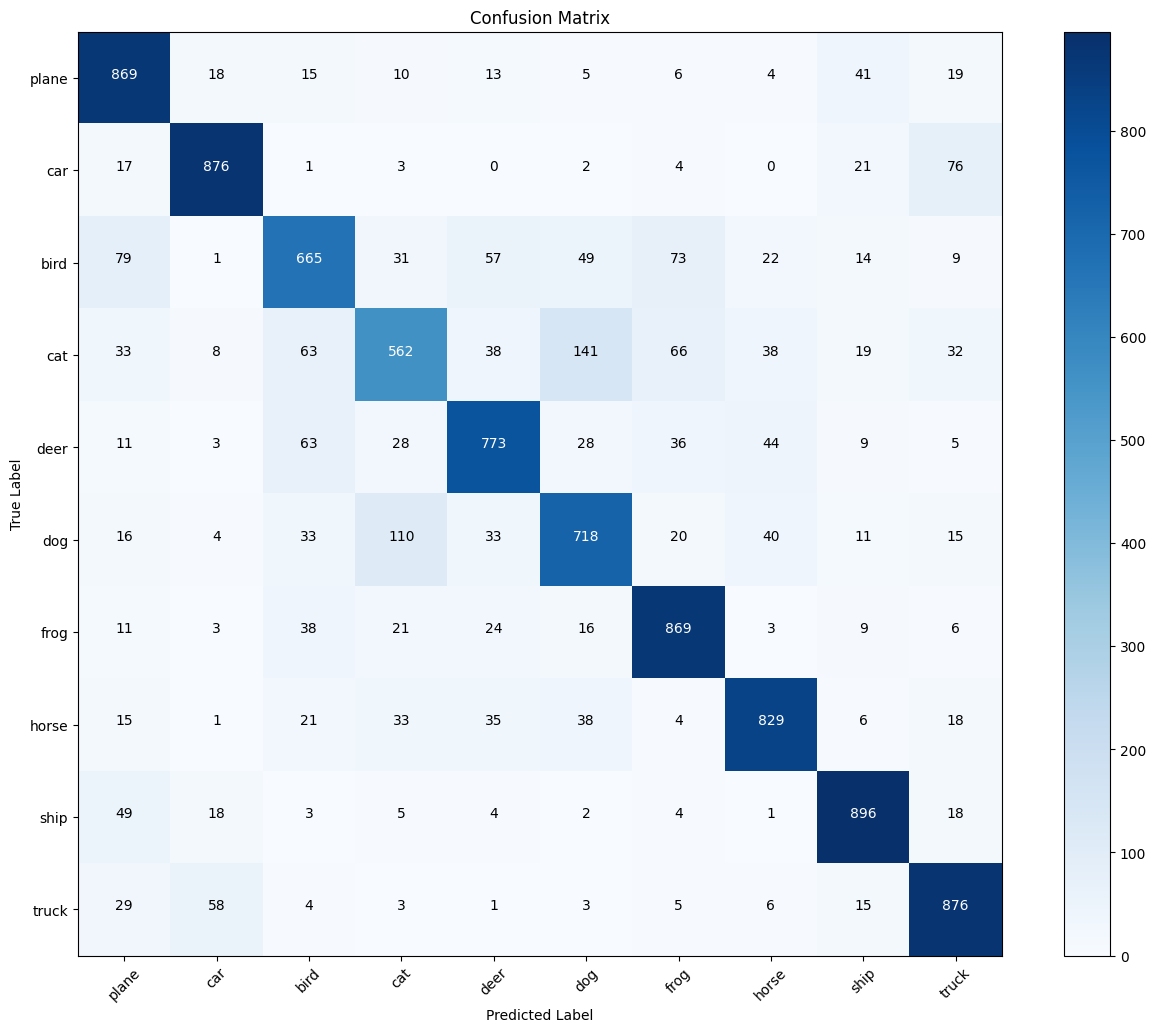

In [13]:
# Plot confusion matrix
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10), classes, rotation=45)
plt.yticks(np.arange(10), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

In [14]:
# Compute accuracy for each class
for i, class_name in enumerate(classes):
    print(f'Accuracy of {class_name}: {cm[i, i] / cm[i].sum() * 100:.2f}%')

Accuracy of plane: 86.90%
Accuracy of car: 87.60%
Accuracy of bird: 66.50%
Accuracy of cat: 56.20%
Accuracy of deer: 77.30%
Accuracy of dog: 71.80%
Accuracy of frog: 86.90%
Accuracy of horse: 82.90%
Accuracy of ship: 89.60%
Accuracy of truck: 87.60%


In [23]:
from torchviz import make_dot
from torchsummary import summary

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Visualize the model
output = net(dummy_input)
dot = make_dot(output, params=dict(net.named_parameters()))

summary(net, (3, 32, 32))
# dot = make_dot(net(torch.zeros(1, 3, 32, 32)))
dot.render("network_structure", format="png")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
       BatchNorm2d-2            [-1, 8, 32, 32]              16
            Conv2d-3           [-1, 16, 32, 32]           1,168
       BatchNorm2d-4           [-1, 16, 32, 32]              32
         MaxPool2d-5           [-1, 16, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           4,640
       BatchNorm2d-7           [-1, 32, 16, 16]              64
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 128, 8, 8]         147,584
      BatchNorm2d-14            [-1, 12

'network_structure.png'

This homework assignment asks you to performs 2 tasks:

1. Analyze Results with Different Network Parameters:

This involves training the network with various configurations of network parameters and analyzing the impact on performance. Here's a step-by-step approach:

**Choose Network Parameters:**

Select the network parameters you want to experiment with. Common choices include:

Number of layers: You can try increasing or decreasing the number of layers in your chosen network architecture (e.g., convolutional layers in a CNN).
Learning rate: Experiment with different learning rates (e.g., 0.01, 0.001, 0.0001) to find a balance between fast learning and stability.
Other parameters: Depending on your network architecture, there might be additional options like:
Number of filters in convolutional layers: This affects the complexity of features extracted from the data.
Activation functions: Experiment with different activation functions (e.g., ReLU, Leaky ReLU) to introduce non-linearity.
Optimizer parameters: Some optimizers (e.g., Adam) have hyperparameters you can adjust.
Train the network for a different number of epochs.

**Analyze Results:**

Compare the performance of the network across different parameter configurations:

How accuracy/loss changes with different parameter values.
2. Show and Explain Errors of the Best Network:

Once you identify the **best performing network configuration** (based on metrics like accuracy or loss), analyze its errors.
For example you can generate a confusion matrix. This matrix visualizes how often the network predicted each class correctly or incorrectly.

Useful resources:
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)



